In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

In [4]:
#@save
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

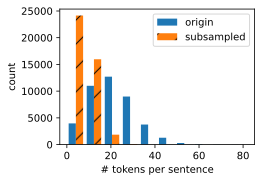

In [5]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

In [6]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2066'

In [7]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 32, 2115, 274, 406], [140, 5277, 3054, 1580]]

In [9]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """ """
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [1]:
import torch

In [25]:
X = torch.randn((12))
Y = torch.randn((12))
Z = torch.zeros_like(X)
id(Z)

2721409449472

In [4]:
Z[:] = X+Y

In [6]:
id(Z)

2721405766592

In [7]:
id(X)

2721401806144

In [8]:
X+=Y


In [26]:
id(X)

2721408790720

In [27]:
a = X.reshape((3,4))

In [28]:
a

tensor([[-0.2196, -1.7870, -0.0847, -2.0121],
        [-2.2980,  0.7467, -0.0622,  0.1874],
        [-0.8296, -0.7981, -0.7108,  0.3745]])

In [29]:
id(a)

2721409454656

In [30]:
X

tensor([-0.2196, -1.7870, -0.0847, -2.0121, -2.2980,  0.7467, -0.0622,  0.1874,
        -0.8296, -0.7981, -0.7108,  0.3745])

In [31]:
b = a.view((3,4))
id(b)

2721409363136

In [33]:
b[:] = 2

In [ ]:
a[:] = 2

In [34]:
a

tensor([[2., 2., 2., 2.],
        [2., 2., 2., 2.],
        [2., 2., 2., 2.]])

In [35]:
X

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [38]:
torch.tensor([2.]).shape

torch.Size([1])

In [39]:
torch.tensor(2.).shape

torch.Size([])

In [44]:
X = torch.randn((3,4))
Y = torch.randn((4))
torch.sum(X,dim=0,keepdim=False).shape

torch.Size([4])

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l


In [10]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    print(X.shape,w.shape)
    y += torch.normal(0, 0.01, y.shape)
    print(y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4]).reshape((2,1))
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000, 2]) torch.Size([2, 1])
torch.Size([1000, 1])


In [29]:
features.shape

torch.Size([1000, 2])

In [8]:
features[torch.tensor(0)]

tensor([1.4105, 0.3029])

In [9]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [24]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000, 2]) torch.Size([2])
torch.Size([1000])


In [25]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [26]:
next(iter(data_iter))

[tensor([[ 0.6061, -0.2048],
         [-1.0846,  1.1070],
         [-0.3569, -0.3051],
         [ 0.4973,  0.1503],
         [ 0.4478,  0.7448],
         [-0.1238,  0.0545],
         [ 0.5029,  0.8500],
         [ 0.3904,  0.3939],
         [ 0.5052,  0.3134],
         [ 0.3495,  1.1681]]),
 tensor([[ 6.0976],
         [-1.7306],
         [ 4.5284],
         [ 4.6869],
         [ 2.5779],
         [ 3.7748],
         [ 2.3024],
         [ 3.6407],
         [ 4.1517],
         [ 0.9322]])]

In [27]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [34]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(),lr=0.03)
epochs = 3
for epoch in range(epochs):
    for X,y in data_iter:
        l = loss(net(X),y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    with torch.no_grad():
        l = loss(net(features),labels)
        print("epoch {} ,loss {}".format(epoch+1,l.numpy()))

epoch 1 ,loss 0.00048107848851941526
epoch 2 ,loss 0.00010761745215859264
epoch 3 ,loss 0.00010752019443316385


In [38]:
features[torch.tensor([0,1])]

tensor([[-0.1238,  0.0545],
        [-0.3120, -0.1953]])

In [ ]:
d2l.load_array()
